### creating the workspace and data
We being by creating a workspace for `deepql`, where we save models, data, etc...

In [6]:
import deepql
import matplotlib.pyplot as plt

# how to use the library
#deepql.help()

In [2]:
# this creates the folder structure used
# deepql.create_workspace()

### data for `force_type="speed"`

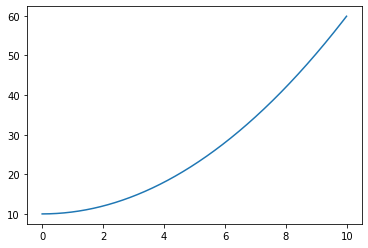

In [6]:
# define the functions for the differential equation to be solved numerically
N_steps = 1000
xi = 10
vi = 0
dt = 1e-2
relative_tolerance = 1e-1

def force_harmonic_oscillator(v):
    return 1

_, sol_status, data = deepql.integrate_diffeq(N=N_steps, xi=xi, vi=vi, 
    dt=dt, 
    force_function=force_harmonic_oscillator, force_type="speed",
    xtol=relative_tolerance)


plt.plot(data[:,0],data[:,1])
plt.show()

In [7]:
# saves the data
deepql.compile_data_to_csv(data, "harmonic_0506")

In [4]:
# now is timee to separate the data
# so its useful for our NN model
import pandas as pd
import deepql

df = pd.read_csv("./gen_data/harmonic_0506.csv")

deepql.separate_data(df, run_length=50, xmax=None, vmax=None)


,x_initial,v_initial,x_step10,v_step10,x_step20,v_step20,x_step30,v_step30,x_step40,v_step40,x_step50,v_step50
0,10.000,0.0,10.005,0.1,10.020,0.2,10.045,0.3,10.080,0.4,10.125,0.5
1,10.005,0.1,10.020,0.2,10.045,0.3,10.080,0.4,10.125,0.5,10.180,0.6
2,10.020,0.2,10.045,0.3,10.080,0.4,10.125,0.5,10.180,0.6,10.245,0.7
3,10.045,0.3,10.080,0.4,10.125,0.5,10.180,0.6,10.245,0.7,10.320,0.8
4,10.080,0.4,10.125,0.5,10.180,0.6,10.245,0.7,10.320,0.8,10.405,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...
90,50.500,9.0,51.405,9.1,52.320,9.2,53.245,9.3,54.180,9.4,55.125,9.5
91,51.405,9.1,52.320,9.2,53.245,9.3,54.180,9.4,55.125,9.5,56.080,9.6
92,52.320,9.2,53.245,9.3,54.180,9.4,55.125,9.5,56.080,9.6,57.045,9.7
93,53.245,9.3,54.180,9.4,55.125,9.5,56.080,9.6,57.045,9.7,58.020,9.8


## Training the model

In [1]:
from deepql.dataset import Dataset, DataLoader

ModuleNotFoundError: No module named 'deepql.dataset'; 'deepql' is not a package

In [5]:
# modulos dentro de deepql
from dataset import MyDataset, DataLoader

import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# informacion para training:
name = ""

csv_file = "./data/" + ""


In [ ]:
my_dataset = MyDataset(pd.read_csv("./data/song_combined_df.csv", index_col=0), step_size=50)
my_dataloader = DataLoader(my_dataset, batch_size=32, shuffle=True)

In [ ]:
# Loading the model
model = torch.load("./model/040223.pt")

In [ ]:


plt.plot(list(model.parameters())[0].detach())
plt.title("Loaded parameters of activation function")
plt.show()

# Hyperparameters
smooth_rate = 0.03
constrain_rate = 1.0 # F(v=0) = 0
targets_rate = 1.05

# Define number of epochs
num_epochs = 50

# Define loss function and optimizer
L2_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.4)

running_loss = 0
loss_array = []

#used for graphs
max_i = len(my_dataloader)

# Iterate through epochs
for epoch in range(num_epochs):
    # Iterate through data in the DataLoader
    for i, data in enumerate(my_dataloader, 0):
        # Get inputs and targets from data
        inputs, targets = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model.forward(inputs)

        L2_computed_loss = L2_loss(outputs, targets)
        # Compute loss
        loss = smooth_rate * smooth_loss(list(model.parameters())[0]) +\
            constrain_rate*physics_constrain(list(model.parameters())[0]) + targets_rate * L2_computed_loss


        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print("L2_loss:", L2_computed_loss.detach().item())
            loss_array.append(L2_computed_loss.detach().item())
            print('[Epoch %d, Mini-batch %5d] Loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    if epoch % 100 == 10:
        # saving the model
        torch.save(model, f"./model/{name}_epoch{epoch}.pt")
        
        #ploting
        plt.plot(list(model.parameters())[0].detach(), alpha = epoch/num_epochs)
        plt.show()
        plt.savefig(f"./evolution_force/{name}_epoch_{epoch}_loss_{running_loss :.2f}.png")


# finish training
torch.save(model, f"./model/{name}_epoch{epoch}.pt")
print('Finished training')

plt.plot(list(model.parameters())[0].detach())
plt.title("After training parameters of activation function")
plt.show()

# plot loss
plt.plot(loss_array)
plt.title("evolution of L2 loss output target")
plt.show()